# Substack Mention Tracker

Track how often specific terms (e.g., **"Claude Code"**, **"AI coding"**) appear in Substack articles over time, grouped by month.

This notebook uses Substack's undocumented search API to fetch article metadata, extract publication dates, and aggregate mention counts into a monthly timeline with a chart and downloadable CSV.

| Property | Value |
|---|---|
| **API Endpoint** | `GET https://substack.com/api/v1/post/search` |
| **Results per page** | 20 |
| **Max pages** | ~100 (hard limit = 2,000 results per query) |
| **Authentication** | None required |
| **Rate limiting** | Handled automatically with exponential backoff |

> **Note:** This is an undocumented API discovered through reverse engineering. It may change without notice.


## Step 1: Install Dependencies

Colab has `requests` and `matplotlib` pre-installed, but we run this cell to be safe.


In [1]:
!pip install -q requests matplotlib pandas


## Step 2: Configure Your Search

Edit the variables below to customize which terms to track and how deep to search.

**Tip:** If you hit rate limits, increase `DELAY_BETWEEN_REQUESTS` to 3 or 4 seconds.


In [2]:
#@title Configuration { display-mode: "form" }

# ── Edit these values ──────────────────────────────────────────────
QUERIES = ["Claude Code", "AI coding"]  #@param {type:"raw"}
MAX_PAGES_PER_QUERY = 100  #@param {type:"integer"}
DELAY_BETWEEN_REQUESTS = 2.0  #@param {type:"number"}
# ──────────────────────────────────────────────────────────────────

print(f"Queries:          {QUERIES}")
print(f"Max pages/query:  {MAX_PAGES_PER_QUERY} ({MAX_PAGES_PER_QUERY * 20} max results)")
print(f"Request delay:    {DELAY_BETWEEN_REQUESTS}s")


Queries:          ['Claude Code', 'AI coding']
Max pages/query:  100 (2000 max results)
Request delay:    2.0s


## Step 3: Define Core Functions

These functions handle API requests, **automatic retry with exponential backoff** on rate-limit (429) errors, pagination, date grouping, and visualization. Run this cell — no edits needed.


In [10]:
import time
import json
import csv
from collections import defaultdict
from datetime import datetime
from io import StringIO

import requests
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

# ── API Configuration ──────────────────────────────────────────────
BASE_URL = "https://substack.com/api/v1/post/search"
MAX_RETRIES = 5       # max retries per page on 429 errors
INITIAL_BACKOFF = 10  # initial wait (seconds) after a 429, doubles each retry

HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/120.0.0.0 Safari/537.36"
    ),
    "Accept": "application/json",
}


def fetch_search_page(query: str, page: int = 0) -> dict:
    """
    Fetch a single page of search results from Substack's API.
    Automatically retries with exponential backoff on HTTP 429.
    """
    params = {
        "query": query,
        "page": page,
        "includePlatformResults": "true",
        "filter": "all",
    }

    backoff = INITIAL_BACKOFF

    for attempt in range(MAX_RETRIES + 1):
        resp = requests.get(BASE_URL, params=params, headers=HEADERS, timeout=30)

        if resp.status_code == 429:
            if attempt < MAX_RETRIES:
                # Respect Retry-After header if present
                retry_after = resp.headers.get("Retry-After")
                if retry_after:
                    try:
                        wait_time = float(retry_after)
                    except ValueError:
                        wait_time = backoff
                else:
                    wait_time = backoff

                print(
                    f"    Rate limited (429) on page {page}. "
                    f"Waiting {wait_time:.0f}s before retry "
                    f"({attempt + 1}/{MAX_RETRIES})..."
                )
                time.sleep(wait_time)
                backoff *= 2  # exponential backoff
                continue
            else:
                print(
                    f"    Rate limited (429) on page {page}. "
                    f"Max retries ({MAX_RETRIES}) exhausted."
                )
                resp.raise_for_status()

        resp.raise_for_status()
        return resp.json()


def fetch_all_results(query: str, max_pages: int = 100, delay: float = 2.0) -> list:
    """
    Paginate through all search results for a query.
    Returns a deduplicated post list. Handles 429 errors gracefully.
    """
    all_results = []
    seen_ids = set()

    for page in range(max_pages):
        try:
            data = fetch_search_page(query, page)
        except requests.exceptions.HTTPError as exc:
            if exc.response is not None and exc.response.status_code in (400, 422):
                print(f"    Reached page limit at page {page}.")
                break
            if exc.response is not None and exc.response.status_code == 429:
                print(f"    Stopping after rate-limit on page {page}. Collected {len(all_results)} results so far.")
                break
            raise

        results = data.get("results", [])
        if not results:
            break

        for post in results:
            pid = post.get("id")
            if pid and pid not in seen_ids:
                seen_ids.add(pid)
                all_results.append(post)

        has_more = data.get("more", False)
        print(
            f"  Page {page:>3d}: fetched {len(results):>2d} results "
            f"(total unique: {len(all_results)})"
        )

        if not has_more:
            break

        time.sleep(delay)

    return all_results


def group_by_month(posts: list) -> dict:
    """Group posts by YYYY-MM and return sorted counts."""
    counts = defaultdict(int)
    for post in posts:
        date_str = post.get("post_date", "")
        if not date_str:
            continue
        try:
            dt = datetime.fromisoformat(date_str.replace("Z", "+00:00"))
            counts[dt.strftime("%Y-%m")] += 1
        except (ValueError, TypeError):
            continue
    return dict(sorted(counts.items()))


def build_full_timeline(monthly_data: dict) -> list:
    """Build a continuous YYYY-MM timeline covering all queries."""
    all_months = set()
    for counts in monthly_data.values():
        all_months.update(counts.keys())
    if not all_months:
        return []

    sorted_months = sorted(all_months)
    start = datetime.strptime(sorted_months[0], "%Y-%m")
    end = datetime.strptime(sorted_months[-1], "%Y-%m")

    timeline = []
    current = start
    while current <= end:
        timeline.append(current.strftime("%Y-%m"))
        if current.month == 12:
            current = current.replace(year=current.year + 1, month=1)
        else:
            current = current.replace(month=current.month + 1)
    return timeline


def extract_pub_name(post: dict) -> str:
    """Safely extract the publication name from a post dict."""
    try:
        bylines = post.get("publishedBylines", [])
        if bylines:
            pub_users = bylines[0].get("publicationUsers", [])
            if pub_users:
                return pub_users[0].get("publication", {}).get("name", "Unknown")
    except (IndexError, KeyError, TypeError):
        pass
    return "Unknown"


print("Core functions loaded (with retry/backoff on 429 errors).")


Core functions loaded (with retry/backoff on 429 errors).


## Step 4: Fetch Data from Substack

This cell queries the Substack search API for each term. Depending on `MAX_PAGES_PER_QUERY`, this may take several minutes.

If the script encounters a rate limit (HTTP 429), it will **automatically wait and retry** with exponential backoff (10s, 20s, 40s, ...) up to 5 times per page. No need to do anything, just let it run.


In [4]:
# ── Fetch all results ─────────────────────────────────────────────
all_posts = {}    # query -> list of post dicts
monthly_data = {} # query -> {month -> count}

for query in QUERIES:
    print(f'\nFetching results for: "{query}"')
    posts = fetch_all_results(query, max_pages=MAX_PAGES_PER_QUERY, delay=DELAY_BETWEEN_REQUESTS)
    all_posts[query] = posts
    monthly_data[query] = group_by_month(posts)
    print(f"  => {len(posts)} total posts found")

timeline = build_full_timeline(monthly_data)
print(f"\nTimeline spans {len(timeline)} months: {timeline[0] if timeline else 'N/A'} to {timeline[-1] if timeline else 'N/A'}")



Fetching results for: "Claude Code"
  Page   0: fetched 20 results (total unique: 20)
  Page   1: fetched 20 results (total unique: 40)
  Page   2: fetched 20 results (total unique: 60)
  Page   3: fetched 20 results (total unique: 80)
  Page   4: fetched 20 results (total unique: 99)
  Page   5: fetched 19 results (total unique: 117)
  Page   6: fetched 20 results (total unique: 136)
  Page   7: fetched 18 results (total unique: 154)
  Page   8: fetched 19 results (total unique: 173)
  Page   9: fetched 20 results (total unique: 192)
  Page  10: fetched 20 results (total unique: 212)
  Page  11: fetched 20 results (total unique: 232)
  Page  12: fetched 20 results (total unique: 252)
  Page  13: fetched 20 results (total unique: 272)
  Page  14: fetched 20 results (total unique: 292)
  Page  15: fetched 20 results (total unique: 312)
  Page  16: fetched 20 results (total unique: 332)
  Page  17: fetched 20 results (total unique: 352)
  Page  18: fetched 20 results (total unique: 371)

## Step 5: View Monthly Counts

A pandas DataFrame showing the number of Substack articles mentioning each term per month.


In [5]:
# ── Build DataFrame ───────────────────────────────────────────────
rows = []
for month in timeline:
    row = {"Month": month}
    for query in QUERIES:
        row[query] = monthly_data[query].get(month, 0)
    rows.append(row)

df = pd.DataFrame(rows)

# Add totals row
totals = {"Month": "TOTAL"}
for query in QUERIES:
    totals[query] = df[query].sum()
df_display = pd.concat([df, pd.DataFrame([totals])], ignore_index=True)

df_display


,Month,Claude Code,AI coding
0,2025-12,1,3
1,2026-01,465,331
2,2026-02,1374,1485
3,TOTAL,1840,1819


## Step 6: Visualize Trends

A line chart showing how mentions have changed over time.


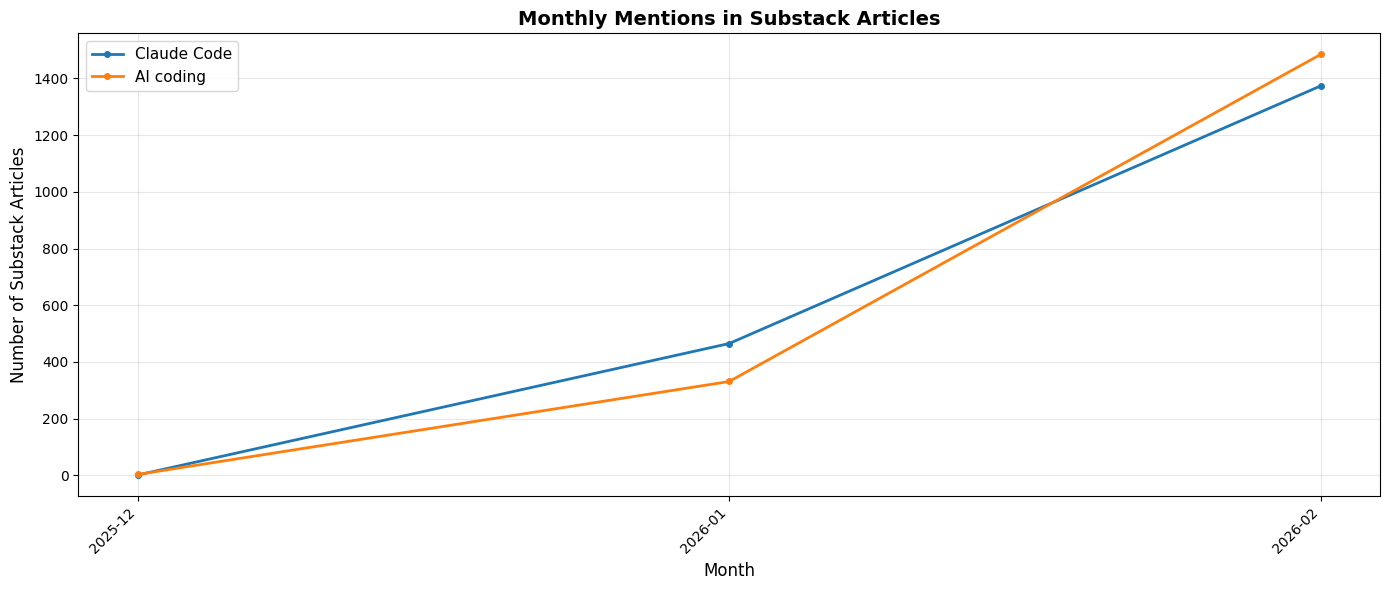

In [6]:
# ── Plot ─────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 6))

for query in QUERIES:
    values = [monthly_data[query].get(m, 0) for m in timeline]
    ax.plot(timeline, values, marker="o", markersize=4, linewidth=2, label=query)

ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Number of Substack Articles", fontsize=12)
ax.set_title("Monthly Mentions in Substack Articles", fontsize=14, fontweight="bold")
ax.legend(fontsize=11)
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.grid(True, alpha=0.3)

# Rotate x-axis labels
step = max(1, len(timeline) // 20)
ax.set_xticks(range(0, len(timeline), step))
ax.set_xticklabels(
    [timeline[i] for i in range(0, len(timeline), step)],
    rotation=45, ha="right"
)

plt.tight_layout()
plt.show()


## Step 7: Download Results

Run the cells below to download the data as CSV or detailed JSON.


In [7]:
# ── Download CSV ─────────────────────────────────────────────────
csv_path = "substack_mentions.csv"
df.to_csv(csv_path, index=False)

try:
    from google.colab import files
    files.download(csv_path)
    print(f"Downloading {csv_path}...")
except ImportError:
    print(f"CSV saved to: {csv_path}")
    print("(Run in Google Colab for automatic download)")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# ── Download detailed JSON (optional) ────────────────────────────
export = {}
for query, posts in all_posts.items():
    export[query] = {
        "total_posts": len(posts),
        "monthly_counts": monthly_data[query],
        "posts": [
            {
                "id": p.get("id"),
                "title": p.get("title"),
                "post_date": p.get("post_date"),
                "canonical_url": p.get("canonical_url"),
                "publication_name": extract_pub_name(p),
                "reaction_count": p.get("reaction_count", 0),
                "comment_count": p.get("comment_count", 0),
                "wordcount": p.get("wordcount", 0),
            }
            for p in sorted(posts, key=lambda x: x.get("post_date", ""), reverse=True)
        ],
    }

json_path = "substack_mentions_detailed.json"
with open(json_path, "w") as f:
    json.dump(export, f, indent=2, ensure_ascii=False)

try:
    from google.colab import files
    files.download(json_path)
    print(f"Downloading {json_path}...")
except ImportError:
    print(f"JSON saved to: {json_path}")
    print("(Run in Google Colab for automatic download)")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Step 8: Explore Top Articles (Bonus)

View the most popular articles for each search term, ranked by reaction count.


In [9]:
# ── Top articles per query ────────────────────────────────────────
TOP_N = 10

for query, posts in all_posts.items():
    print(f'\n{"=" * 60}')
    print(f'  Top {TOP_N} articles for "{query}"')
    print(f'{"=" * 60}')

    sorted_posts = sorted(posts, key=lambda p: p.get("reaction_count", 0), reverse=True)

    for i, p in enumerate(sorted_posts[:TOP_N], 1):
        title = p.get("title", "Untitled")
        reactions = p.get("reaction_count", 0)
        date = p.get("post_date", "")[:10]
        pub = extract_pub_name(p)
        url = p.get("canonical_url", "")
        print(f"\n  {i:>2}. [{reactions:>4} likes] {title}")
        print(f"      {pub} · {date}")
        print(f"      {url}")



  Top 10 articles for "Claude Code"

   1. [2707 likes] The AI revolution is here. Will the economy survive the transition?
      Unknown · 2026-01-09
      https://post.substack.com/p/the-ai-revolution-is-here-will-the

   2. [2120 likes] Building an Institutional-Grade Portfolio Tracker with AI
      Mispriced Assets · 2026-01-25
      https://mispricedassets.substack.com/p/building-an-institutional-grade-portfolio

   3. [1270 likes] Claude Code and What Comes Next
      One Useful Thing · 2026-01-07
      https://www.oneusefulthing.org/p/claude-code-and-what-comes-next

   4. [1162 likes] Claude Code for Everything: Finally, that Personal Assistant You’ve Always Wanted
      In the Weeds · 2026-01-09
      https://hannahstulberg.substack.com/p/claude-code-for-everything-finally

   5. [1092 likes] How I Built My Personal AI Assistant (Claude Code Tutorial)
      MICHAEL CRIST · 2026-01-18
      https://michaelcrist.substack.com/p/personal-ai-assistant

   6. [ 846 likes] Best Of M

---

## Notes & Limitations

1. **Undocumented API.** The endpoint `substack.com/api/v1/post/search` is not part of Substack's official API and could change at any time.

2. **~2,000 result cap per query.** Substack returns at most ~100 pages of 20 results. For very popular terms, older results may be truncated. Consider running monthly and accumulating data.

3. **Relevance-based search.** Results are ranked by relevance, not strict substring matching. A search for "AI coding" may return articles mentioning "AI" and "coding" separately.

4. **Rate limiting.** The script automatically retries with exponential backoff (10s → 20s → 40s → 80s → 160s) on HTTP 429 errors, up to 5 times per page. If you still hit limits, increase `DELAY_BETWEEN_REQUESTS` in Step 2.

5. **Customization.** Edit the `QUERIES` list in Step 2 to track any terms you like. You can add as many as you want.
